## 📘 Introducción

En este notebook se abordará el desarrollo de modelos de regresión para predecir el consumo de energía de edificaciones, en función de características relacionadas con su diseño y configuración.

Utilizaremos diversos algoritmos de machine learning para comparar su desempeño y posteriormente optimizarlos. Se evaluará cada modelo en términos de métricas de error y capacidad predictiva, buscando un equilibrio entre precisión y generalización.

Este flujo de trabajo seguirá los siguientes pasos:

*  Carga y preparación de los datos  
*  Separación en conjunto de entrenamiento y prueba  
*  Entrenamiento de modelos base (baseline)  
*  Optimización de hiperparámetros en distintos modelos
*  Evaluación comparativa  
*  Análisis de resultados y selección del modelo final


# Librerías y Carga de los datos

In [1]:
# Librerías necesarias
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), 'src'))
from utils_EDA import evaluate_models

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [2]:
X = pd.read_csv('../data/features.csv')
y1 = pd.read_csv('../data/y_heating.csv')
y2 = pd.read_csv('../data/y_cooling.csv')

# Renombrar columnas para mayor claridad (según documentación UCI)
X.columns = [
    'Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area',
    'Overall_Height', 'Orientation', 'Glazing_Area',
    'Glazing_Area_Distribution']

y1.columns = ['Heating_Load']
y2.columns = ['Cooling_Load']

In [3]:
# División de datos: usaremos 80% entrenamiento y 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y1, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (614, 8)
Test shape: (154, 8)


## 🔍 Modelo Baseline

Para establecer una línea base de rendimiento, en esta sección implementaremos un **modelo de regresión Ridge**, el cual será nuestro punto de comparación inicial.

Este modelo es una versión regularizada de la regresión lineal, que introduce una penalización sobre los coeficientes del modelo, lo que ayuda a prevenir el sobreajuste en presencia de multicolinealidad o muchas variables independientes.

En la siguiente sección se explorarán y optimizarán otros modelos más complejos, como:
- Árboles de Decisión
- Random Forest
- K-Nearest Neighbors (KNN)

### 🔧 Métricas utilizadas

Evaluaremos el modelo con las siguientes métricas:

- **MAE** (Mean Absolute Error): Promedio del error absoluto, fácil de interpretar.
- **RMSE** (Root Mean Squared Error): Penaliza más fuertemente los errores grandes.
- **R² Score**: Cuantifica la proporción de la varianza explicada por el modelo.


In [4]:
# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenamiento del modelo Ridge
ridge = Ridge()
ridge.fit(X_train_scaled, y_train)

# Predicciones
y_pred = ridge.predict(X_test_scaled)

In [5]:
# Evaluación
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Resultados
print("Evaluación del modelo Ridge (baseline):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

Evaluación del modelo Ridge (baseline):
MAE:  2.1908
RMSE: 3.0354
R²:   0.9116


### 📌 Observaciones

El modelo de regresión Ridge ha logrado un buen desempeño inicial considerando que no se ha realizado ajuste de hiperparámetros. 

- El **MAE de 2.19** indica que, en promedio, las predicciones se desvían en torno a 2.2 unidades del valor real.
- El **RMSE de 3.03**, al ser ligeramente mayor al MAE, sugiere que existen algunos errores más grandes, pero sin ser excesivamente severos.
- El **R² de 0.91** muestra que el modelo explica más del 90% de la varianza de la variable objetivo, lo cual es un muy buen punto de partida.

Este resultado servirá como referencia para evaluar si modelos más complejos o ajustados pueden superar esta línea base.


## 🌲 Modelos de Regresión: Entrenamiento y Optimización

En esta sección se implementarán distintos modelos de regresión para predecir el consumo energético, evaluando su rendimiento mediante validación cruzada y optimización de hiperparámetros. Los modelos considerados serán:

- Árboles de Decisión
- Random Forest
- K-Nearest Neighbors (KNN)

Cada modelo será entrenado con **`GridSearchCV`** y **`BayesSearchCV`**, para encontrar la mejor configuración posible, y luego se evaluará en el conjunto de prueba usando las métricas **MAE**, **RMSE** y **R²**.

Los datos serán previamente estandarizados con `StandardScaler` tal como se hizo con el modelo baseline.

---

### 🌳 Modelo 1: Árbol de Decisión (Decision Tree Regressor)


In [6]:
dt = DecisionTreeRegressor(random_state=42)

**Optimización con GridSearchCV**

In [7]:
# Hiperparámetros a optimizar
param_grid = {
    'max_depth': [3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV
grid_search_dt = GridSearchCV(
    dt, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1
)

grid_search_dt.fit(X_train_scaled, y_train)

print("🔎 Mejor configuración (GridSearchCV):")
print(grid_search_dt.best_params_)

🔎 Mejor configuración (GridSearchCV):
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [8]:
best_dt_model_gs = grid_search_dt.best_estimator_
y_pred_dt = best_dt_model_gs.predict(X_test_scaled)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = mean_squared_error(y_test, y_pred_dt, squared=False)
r2_dt = r2_score(y_test, y_pred_dt)

print("\n📊 Evaluación Árbol de Decisión (GridSearchCV):")
print(f"MAE:  {mae_dt:.4f}")
print(f"RMSE: {rmse_dt:.4f}")
print(f"R²:   {r2_dt:.4f}")
print("Mejores hiperparámetros:", grid_search_dt.best_params_)


📊 Evaluación Árbol de Decisión (GridSearchCV):
MAE:  0.4118
RMSE: 0.6175
R²:   0.9963
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}


**Optimización con BayesSearchCV**

In [9]:
# BayesSearchCV
param_space = {
    'max_depth': Integer(3, 20),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 10)
}

bayes_search_dt = BayesSearchCV(
    dt,
    search_spaces=param_space,
    cv=5,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
bayes_search_dt.fit(X_train_scaled, y_train)

BayesSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
              random_state=42, scoring='neg_root_mean_squared_error',
              search_spaces={'max_depth': Integer(low=3, high=20, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize')})

In [10]:
best_dt_model_bs = bayes_search_dt.best_estimator_
y_pred_dt = best_dt_model_bs.predict(X_test_scaled)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = mean_squared_error(y_test, y_pred_dt, squared=False)
r2_dt = r2_score(y_test, y_pred_dt)

print("\n📊 Evaluación Árbol de Decisión (BayesSearchCV):")
print(f"MAE:  {mae_dt:.4f}")
print(f"RMSE: {rmse_dt:.4f}")
print(f"R²:   {r2_dt:.4f}")
print("Mejores hiperparámetros:", bayes_search_dt.best_params_)


📊 Evaluación Árbol de Decisión (BayesSearchCV):
MAE:  0.3955
RMSE: 0.5652
R²:   0.9969
Mejores hiperparámetros: OrderedDict([('max_depth', 7), ('min_samples_leaf', 1), ('min_samples_split', 2)])


#### 📌 Observaciones - Árbol de Decisión

El modelo de Árbol de Decisión mostró un desempeño sobresaliente en la predicción del consumo energético, con métricas significativamente mejores que el modelo baseline (Ridge). Se evaluaron dos estrategias de optimización:

- **GridSearchCV**: entregó una configuración con un **MAE de 0.4118**, **RMSE de 0.6175** y un **R² de 0.9963**.
- **BayesSearchCV**: mejoró ligeramente el rendimiento con un **MAE de 0.3955**, **RMSE de 0.5652** y un **R² de 0.9969**.

> Estos resultados indican que el modelo es capaz de capturar de forma efectiva la relación entre las variables predictoras y el consumo energético, y que el uso de técnicas avanzadas de búsqueda de hiperparámetros (como BayesSearch) puede entregar beneficios adicionales en términos de precisión.


---
### 🌳🌳 Modelo 2: RandomForestRegressor

In [11]:
rf = RandomForestRegressor(random_state=42)

**Optimización con GridSearchCV**

In [12]:
# Definir la grilla de hiperparámetros
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Ejecutar GridSearchCV
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                       cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_rf.fit(X_train, y_train.values.ravel())  # Aplanar y_train para evitar errores de forma

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [13]:
# Mejor modelo
best_rf_grid = grid_rf.best_estimator_

# Evaluación
y_pred_grid = best_rf_grid.predict(X_test)
print("📊 Evaluación Random Forest (GridSearchCV):")
print("MAE: ", mean_absolute_error(y_test, y_pred_grid))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_grid)))
print("R²:  ", r2_score(y_test, y_pred_grid))
print("Mejores hiperparámetros:", grid_rf.best_params_)

📊 Evaluación Random Forest (GridSearchCV):
MAE:  0.35489545454545424
RMSE: 0.49263764916683306
R²:   0.9976716085106088
Mejores hiperparámetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


**Optimización con BayesSearchCV**

In [14]:
# Definir espacio de búsqueda
param_bayes_rf = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(5, 30),
    'min_samples_split': Integer(2, 10)
}

# Ejecutar BayesSearchCV
bayes_rf = BayesSearchCV(
    estimator=rf,
    search_spaces=param_bayes_rf,
    cv=5,
    n_iter=30,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

bayes_rf.fit(X_train, y_train.values.ravel())

BayesSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_iter=30,
              n_jobs=-1, random_state=42, scoring='neg_mean_squared_error',
              search_spaces={'max_depth': Integer(low=5, high=30, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=300, prior='uniform', transform='normalize')})

In [15]:
# Mejor modelo
best_rf_bayes = bayes_rf.best_estimator_

# Evaluación
y_pred_bayes = best_rf_bayes.predict(X_test)
print("📊 Evaluación Random Forest (BayesSearchCV):")
print("MAE: ", mean_absolute_error(y_test, y_pred_bayes))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_bayes)))
print("R²:  ", r2_score(y_test, y_pred_bayes))
print("Mejores hiperparámetros:", bayes_rf.best_params_)

📊 Evaluación Random Forest (BayesSearchCV):
MAE:  0.3520671057513881
RMSE: 0.4895930573107531
R²:   0.9977002993591738
Mejores hiperparámetros: OrderedDict([('max_depth', 12), ('min_samples_split', 2), ('n_estimators', 300)])


#### 📌 Observaciones – Random Forest

El modelo **Random Forest** mostró un rendimiento sobresaliente en ambas estrategias de optimización:

- **Con `GridSearchCV`**:
  - 📉 **MAE**: 0.3549  
  - 📈 **RMSE**: 0.4926  
  - ✅ **R²**: 0.9977

- **Con `BayesSearchCV`**:
  - 📉 **MAE**: 0.3521  
  - 📈 **RMSE**: 0.4896  
  - ✅ **R²**: 0.9977

> Estos resultados reflejan una capacidad de predicción **altamente precisa**, superando no solo al modelo **baseline Ridge**, sino también al **Árbol de Decisión** en todas las métricas.


---
### 🤝 Modelo 3: K-Nearest Neighbors Regressor

In [16]:
# Pipeline con escalamiento
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])
pipe_knn

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])

**Optimización con GridSearchCV**

In [17]:
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

grid_knn = GridSearchCV(
    estimator=pipe_knn,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 11], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [18]:
best_knn_grid = grid_knn.best_estimator_

y_pred_grid = best_knn_grid.predict(X_test)
print("📊 Evaluación KNN (GridSearchCV):")
print(f"MAE:  {mean_absolute_error(y_test, y_pred_grid):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_grid)):.4f}")
print(f"R²:   {r2_score(y_test, y_pred_grid):.4f}")
print("Mejores hiperparámetros:", grid_knn.best_params_)

📊 Evaluación KNN (GridSearchCV):
MAE:  0.6395
RMSE: 0.9075
R²:   0.9921
Mejores hiperparámetros: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}


**Optimización con BayesSearchCV**

In [19]:
param_bayes = {
    'knn__n_neighbors': (2, 20),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': (1, 2)
}

bayes_knn = BayesSearchCV(
    estimator=pipe_knn,
    search_spaces=param_bayes,
    n_iter=30,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

bayes_knn.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                        ('knn', KNeighborsRegressor())]),
              n_iter=30, n_jobs=-1, random_state=42,
              scoring='neg_mean_squared_error',
              search_spaces={'knn__n_neighbors': (2, 20), 'knn__p': (1, 2),
                             'knn__weights': ['uniform', 'distance']})

In [20]:
best_knn_bayes = bayes_knn.best_estimator_
y_pred_bayes = best_knn_bayes.predict(X_test)

print("\n📊 Evaluación KNN (BayesSearchCV):")
print(f"MAE:  {mean_absolute_error(y_test, y_pred_bayes):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_bayes)):.4f}")
print(f"R²:   {r2_score(y_test, y_pred_bayes):.4f}")
print("Mejores hiperparámetros:", bayes_knn.best_params_)


📊 Evaluación KNN (BayesSearchCV):
MAE:  0.5260
RMSE: 0.8226
R²:   0.9935
Mejores hiperparámetros: OrderedDict([('knn__n_neighbors', 2), ('knn__p', 1), ('knn__weights', 'distance')])


#### 📌 Observaciones - K-Nearest Neighbors Regressor (KNN)

El modelo **K-Nearest Neighbors Regressor (KNN)** logró desempeños competitivos, especialmente tras la optimización de hiperparámetros con búsqueda bayesiana.

- Con `GridSearchCV`, el modelo alcanzó un **R² de 0.9921**, lo que indica una capacidad de predicción bastante sólida, aunque con errores algo más elevados comparado con otros modelos.
- Al aplicar `BayesSearchCV`, se obtuvo un **R² aún mayor (0.9935)** y una reducción significativa del error absoluto y cuadrático medio (**MAE = 0.5260**, **RMSE = 0.8226**), lo que demuestra el valor de una optimización más eficiente del espacio de hiperparámetros.

> En ambos casos, el modelo prefirió trabajar con un número muy reducido de vecinos (2 o 3) y una ponderación por distancia, lo que sugiere que las observaciones más cercanas (y con mayor influencia) son altamente representativas para la predicción.


---

## 📊 Comparación Final de Modelos

En esta sección se comparan los modelos entrenados y optimizados mediante distintas técnicas de búsqueda de hiperparámetros, específicamente **GridSearchCV** y **BayesSearchCV**.

Los modelos evaluados fueron:

- Ridge Regression (baseline)  
- Decision Tree Regressor  
- Random Forest Regressor  
- K-Nearest Neighbors Regressor  

Cada uno fue evaluado utilizando las siguientes métricas sobre el conjunto de test:

- **MAE** (Error Absoluto Medio): mide la magnitud promedio de los errores sin considerar su dirección.
- **RMSE** (Raíz del Error Cuadrático Medio): penaliza más fuertemente los errores grandes.
- **R² Score** (Coeficiente de determinación): representa qué tan bien el modelo explica la variabilidad de los datos.


In [21]:
models = {
    'Ridge': ridge,
    'Decision Tree (Grid)': best_dt_model_gs,
    'Decision Tree (Bayes)': best_dt_model_bs,
    'Random Forest (Grid)': best_rf_grid,
    'Random Forest (Bayes)': best_rf_bayes,
    'KNN (Grid)': best_knn_grid,
    'KNN (Bayes)': best_knn_bayes
}

# Modelos que necesitan datos escalados
scaled_models = ['Ridge', 'Decision Tree (Grid)', 'Decision Tree (Bayes)']


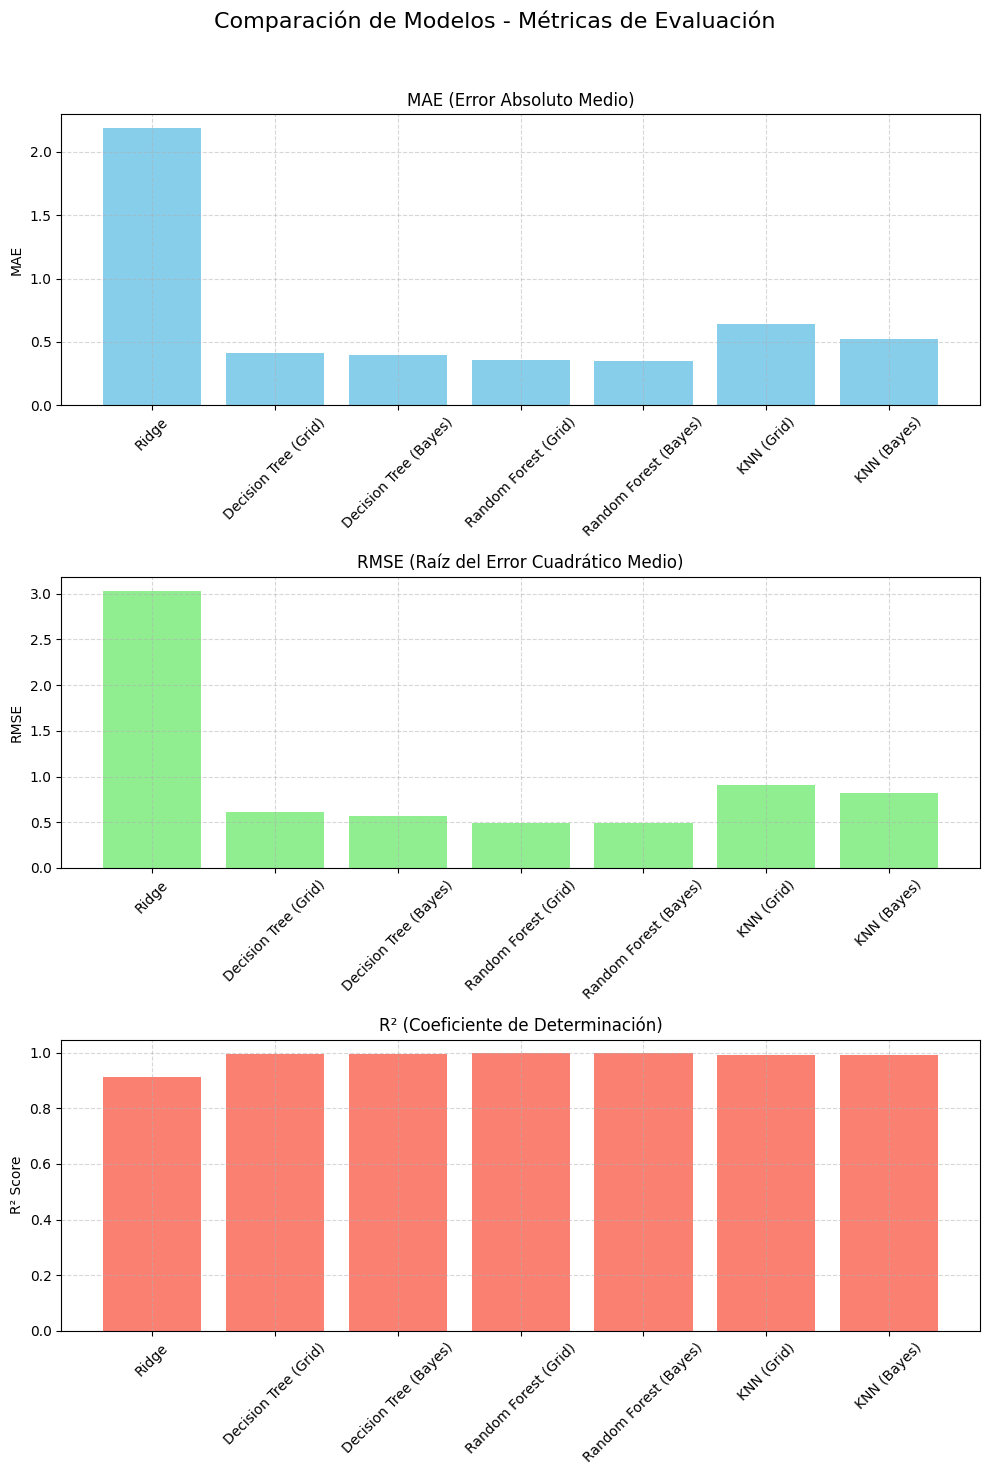

In [22]:
results_df = evaluate_models(models, X_test, y_test, X_test_scaled=X_test_scaled, use_scaled_for=scaled_models)

In [23]:
results_df

,Model,MAE,RMSE,R²
0,Random Forest (Bayes),0.352067,0.489593,0.997700
1,Random Forest (Grid),0.354895,0.492638,0.997672
2,Decision Tree (Bayes),0.395482,0.565185,0.996935
3,Decision Tree (Grid),0.411792,0.617530,0.996341
4,KNN (Bayes),0.526032,0.822649,0.993507
5,KNN (Grid),0.639481,0.907456,0.992100
6,Ridge,2.190753,3.035429,0.911602


### ✅ Conclusión de la Comparación de Modelos

Tras evaluar el desempeño de los modelos de regresión con diferentes técnicas de optimización de hiperparámetros, se pueden destacar las siguientes observaciones clave:

- El modelo **Random Forest optimizado con BayesSearchCV** obtuvo el **mejor desempeño general**, alcanzando el menor MAE (0.35), RMSE (0.49) y el mayor R² (0.9977), lo que indica una excelente capacidad predictiva.
- **Random Forest con GridSearchCV** también mostró un rendimiento muy similar, apenas por debajo del modelo optimizado con búsqueda bayesiana.
- Ambos modelos de **Árboles de Decisión** (tanto con Bayes como Grid) lograron un desempeño competitivo, aunque ligeramente inferior al de Random Forest.
- El modelo **K-Nearest Neighbors**, a pesar de mostrar buenos resultados, tuvo un rendimiento algo menor, especialmente en su versión optimizada por GridSearchCV.
- Por último, el modelo **Ridge** (utilizado como baseline) presentó una precisión considerablemente inferior respecto a los demás modelos, lo que reafirma la necesidad de utilizar algoritmos más complejos y ajustados para este problema.

📌 **Conclusión general:**  
El modelo más recomendable para este problema de predicción del consumo energético es **Random Forest Regressor optimizado con BayesSearchCV**, por su alto desempeño en todas las métricas evaluadas.


## 🔮 Trabajos Futuros

Si bien los modelos implementados han logrado un rendimiento sobresaliente —especialmente el Random Forest optimizado con BayesSearchCV—, existen diversas oportunidades para extender y mejorar este proyecto en el futuro:

- **Incorporar nuevos algoritmos**: Explorar modelos más avanzados como Gradient Boosting (XGBoost, LightGBM o CatBoost) o redes neuronales, que podrían captar relaciones no lineales complejas en los datos.
- **Análisis de importancia de variables**: Evaluar el impacto individual de cada característica mediante técnicas como SHAP o Permutation Importance para obtener interpretaciones más robustas.
- **Feature engineering**: Investigar la creación de nuevas variables derivadas o transformaciones de las actuales que puedan mejorar la capacidad predictiva del modelo.
- **Validación robusta**: Implementar validaciones cruzadas más sofisticadas (por ejemplo, nested cross-validation) para asegurar que los resultados obtenidos no estén sobreajustados.
- **Implementación en producción**: Desarrollar una API o dashboard interactivo donde se pueda cargar un nuevo set de características y obtener predicciones al instante.
- **Ampliar el análisis a la otra variable objetivo** (`Y2`) incluida en el dataset, con un flujo de trabajo similar.

Estas mejoras permitirían no solo refinar el modelo, sino también extender su aplicabilidad práctica a contextos reales de eficiencia energética.

---

🚀 ¡Con esto concluye el proyecto!
